# Data sourcing

lets see where the data takes us ey ;)

In [1]:
import warnings

from datetime import datetime

import pandas as pd
import pandas_datareader as pdr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings('ignore')

## Joes data (webscraped I think?)

guess we'll start with looking at the provided data and see what more we might like to encorporate.

In [8]:
df = pd.read_csv('data/sp500_measures_joe.csv')

df['Date'] = pd.to_datetime(df['Date'].str[:10], format='%Y-%m-%d')
df['Ticker'] = df['Ticker'].str.upper()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8682 entries, 0 to 8681
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        8682 non-null   datetime64[ns]
 1   Unix                        8682 non-null   float64       
 2   Ticker                      8682 non-null   object        
 3   Price                       8578 non-null   float64       
 4   stock_p_change              8578 non-null   float64       
 5   SP500                       8682 non-null   float64       
 6   SP500_p_change              8682 non-null   float64       
 7   Market Cap                  8593 non-null   float64       
 8   Enterprise Value            8548 non-null   float64       
 9   Trailing PE                 7887 non-null   float64       
 10  Forward PE                  8350 non-null   float64       
 11  PEG Ratio                   8215 non-null   float64     

not too NULL which is exciting, just to check if its a few bad eggs causing all the empties we'll chuck out an absolutely  *classic* NULL heatmap

<AxesSubplot:>

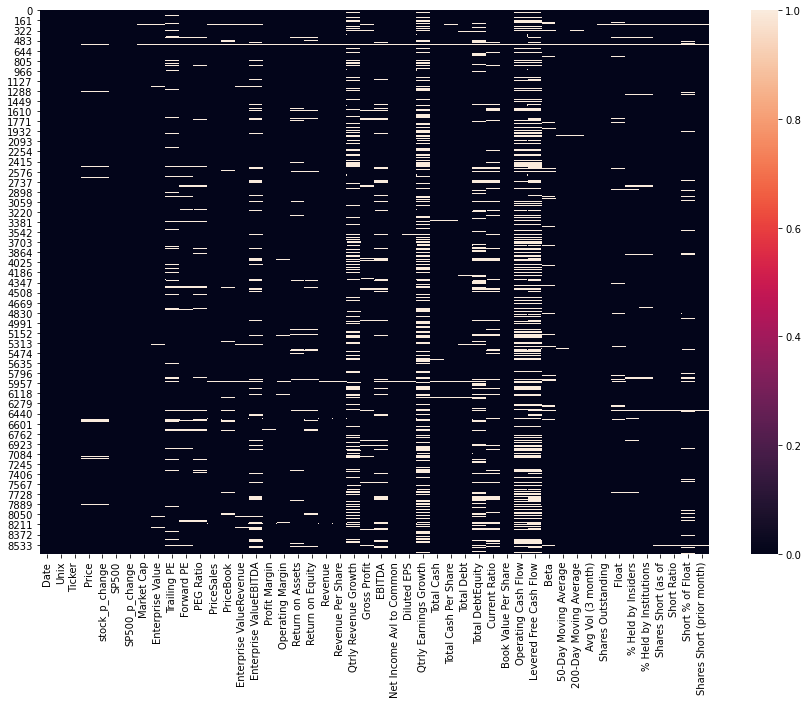

In [41]:
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(df.isnull(), ax=ax)

ok I'd like to get a feel for the periodicity of the data and the time series covered actually, and then we can look to maybe build some extra columns like maybe rolling average columns if the data allows - I dont know in stock terms but for crypto the 20 week moving average usually acts as meaningful support so If the data is daily / weekly I'd like to slap that on there too

the time series ranges from 2003-10-02 to 2013-09-06


Text(0, 0.5, 'number of rows')

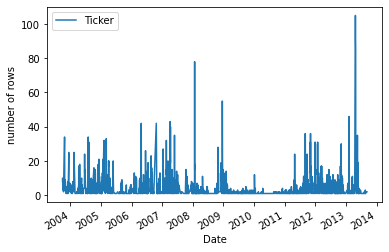

In [36]:
print(f"the time series ranges from {str(df['Date'].min())[:10]} to {str(df['Date'].max())[:10]}")

ax = df[['Date', 'Ticker']].groupby('Date').count().plot()
ax.set_ylabel('number of rows')

... this is pretty squiff lol - We'd want this to be relatively consistant over time if the data had consistant periodicity. This looks like the data exists only on specific dates rather than all tickers all the time and also like those specific dates may be arbitrary rather than equally spaced? cool that its centered on 2008 though - should capture the financial crisis?

## Daily Ticker data (gimped yahoo finance yank)

Prehaps it would be worth using pandas_datareader to yank the stock price down for the missing dates and just interpolating the other colunmns between the known dates? - better yet keep the data all relational and the prices separate from the rest could be a shout - assuming this sp_500 data does in fact have 500 tickers there could be quite alot of data involved in the download. (i.e. 10 years * 365 days * ~500 tickers = 1,825,000)

In [20]:
tickers = df['Ticker'].unique().tolist()
start_date = df['Date'].min().strftime('%Y-%m-%d')
end_date = df['Date'].max().strftime('%Y-%m-%d')

prices = pdr.DataReader(tickers, data_source='yahoo', start=start_date, end=end_date)
prices.to_csv('data/raw_price_output.csv')
prices.head()

Attributes  Adj Close                                                       \
Symbols          CTAS         VZ       GME       AMZN       CNP        CAT   
Date                                                                         
2003-10-02  29.806219  12.656958  5.581658  50.090000  4.281927  22.713688   
2003-10-03  31.261112  12.831902  5.615324  52.889999  4.309852  22.926140   
2003-10-06  31.300026  12.854723  5.807212  54.150002  4.333123  23.122976   
2003-10-07  31.797960  12.740627  5.807212  54.910000  4.323814  23.251074   
2003-10-08  31.821306  12.573266  5.749982  55.700001  4.300541  23.529135   

Attributes                               ... Volume                            \
Symbols         AAPL      BF-B ZNGA  PM  ...    STI DSW TMK UTX LUK FLIR PCLN   
Date                                     ...                                    
2003-10-02  0.314928  5.976847  NaN NaN  ...    NaN NaN NaN NaN NaN  NaN  NaN   
2003-10-03  0.332075  5.983544  NaN NaN  ...    NaN NaN NaN NaN NaN  NaN  NaN   
2003-10-06  0.341262  6.060903  NaN NaN  ...    NaN NaN NaN NaN NaN  NaN  NaN   
2003-10-07  0.355500  6.177687  NaN NaN  ...    NaN NaN NaN NaN NaN  NaN  NaN   
2003-10-08  0.353051  6.125622  NaN NaN  ...    NaN NaN NaN NaN NaN  NaN  NaN   

Attributes               
Symbols    DLPH NYX  XL  
Date                     
2003-10-02  NaN NaN NaN  
2003-10-03  NaN NaN NaN  
2003-10-06  NaN NaN NaN  
2003-10-07  NaN NaN NaN  
2003-10-08  NaN NaN NaN  

[5 rows x 2826 columns]

yikes that took its time to download - Im thinking save to a parquet per year and then swap to pyspark for the continuation fo what we doin' here bois as I think using this in local pandas may be a bit of a stretch. gives a chance to go back o some big data tools at least and prehaps even to get a chance to use spark.ml. might even gzip it for old times sake

In [43]:
prices = pd.read_csv('data/raw_price_output.csv', index_col=[0], header=[0,1])  # so dont have to re-download

prices = prices.reset_index().melt(id_vars='Date')
prices = prices.pivot(index=['Date', 'Symbols'], columns='Attributes', values='value').reset_index()
prices.dropna(axis=0, inplace=True)

prices['Date'] = pd.to_datetime(prices['Date'], format='%Y-%m-%d')
prices['year'] = prices['Date'].dt.year
prices.columns = [col.lower().replace(' ', '_') for col in prices.columns]
prices.rename(columns={'symbols': 'ticker'}, inplace=True)

prices.sort_values(by=['ticker', 'date'], inplace=True)  # so rolling works
prices['140_day_rolling_avg'] = prices.groupby('ticker')['close'].rolling(140, 1).mean().reset_index(0, drop=True)
prices['bigger_140_avg'] = np.where(prices['close'] > prices['140_day_rolling_avg'], 1, 0)
prices['200_day_rolling_avg'] = prices.groupby('ticker')['close'].rolling(200, 1).mean().reset_index(0, drop=True)
prices['bigger_200_avg'] = np.where(prices['close'] > prices['200_day_rolling_avg'], 1, 0)
prices['growth_rate'] = prices.groupby('ticker')['close'].transform('pct_change')

prices.to_parquet('data/yahoo_prices', compression='gzip', index=False, partition_cols=['year'])

prices.head()

,date,ticker,adj_close,close,high,low,open,volume,year,140_day_rolling_avg,bigger_140_avg,200_day_rolling_avg,bigger_200_avg,growth_rate
0,2003-10-02,A,13.544954,15.729614,15.865522,15.622318,15.808298,3370159.0,2003,15.729614,0,15.729614,0,NaN
471,2003-10-03,A,14.167073,16.452074,16.788269,15.894134,16.523605,5273815.0,2003,16.090844,1,16.090844,1,0.045930
942,2003-10-06,A,14.185552,16.473534,16.616594,16.316166,16.452074,1366685.0,2003,16.218407,1,16.218407,1,0.001304
1413,2003-10-07,A,14.431934,16.759657,16.852648,16.237482,16.380545,2712819.0,2003,16.353720,1,16.353720,1,0.017369
1884,2003-10-08,A,14.419623,16.745352,16.988556,16.609442,16.938484,2300968.0,2003,16.432046,1,16.432046,1,-0.000854


beautiful, although theres a question of whether the close is indeed the price I shouldve used to anchor those extra columns here - would the daily average have made more sense? I'll just check the coverage as I'm fairly sure that dropna's command lost me at least a couple of tickers entirely?

In [86]:
syms = prices['symbols'].unique().tolist()
tickers = df['Ticker'].unique().tolist()

missing_ticks = [ticker for ticker in tickers if ticker not in syms]

print(missing_ticks)
print(f'\nthe percentage of tickers missing from prices df is {round(len(missing_ticks) / len(tickers) * 100)}%')

['AGN', 'CBG', 'WPX', 'HRS', 'PX', 'CELG', 'TIF', 'CBS', 'RTN', 'JCP', 'ALXN', 'DF', 'APC', 'ETFC', 'ESV', 'DO', 'HCN', 'IR', 'LM', 'WIN', 'SHLD', 'RSH', 'SFLY', 'DNB', 'SCG', 'COG', 'NTRI', 'CCE', 'VAR', 'WTW', 'RDC', 'S', 'DPS', 'MON', 'RHT', 'WYN', 'FTR', 'CHK', 'SNE', 'SKS', 'JEC', 'HCP', 'MYL', 'NE', 'AVP', 'SAI', 'SYMC', 'MOLX', 'NBL', 'VIAB', 'TSS', 'BKS', 'DNR', 'QEP', 'BBT', 'CTL', 'GCI', 'STI', 'DSW', 'TMK', 'UTX', 'LUK', 'FLIR', 'PCLN', 'DLPH', 'NYX', 'XL']

the percentage of tickers missing from prices df is 14%


cock - we've lost 14% of the tickers. I guess this cant be avoided though so ack well moving swiftly on